In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None # essa linha impede o surgimento de alguns alertas

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.cluster import KMeans

# Importando a Base de Dados

In [2]:
penguins = sns.load_dataset('penguins')

In [3]:
penguins.head()

species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
3  Adelie  Torgersen             NaN            NaN                NaN   
4  Adelie  Torgersen            36.7           19.3              193.0   

   body_mass_g     sex  
0       3750.0    Male  
1       3800.0  Female  
2       3250.0  Female  
3          NaN     NaN  
4       3450.0  Female

In [4]:
penguins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [5]:
penguins.isnull().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

In [6]:
px.imshow(penguins.isna(),title="Heatmap de Valores Nulos")

Percebemos que a maioria dos valores nulos encontram-se na coluna "sex". Iremos usar uma metodologia de machine learning para tentar identificar corretamente quais seriam esse valores. 

Os demais valores nulos aparentemente são erros de coleta, pois estão vazios para a maioria das medições. Por isso esses valores serão retirados da base de dados.

In [7]:
penguins.dropna(subset="bill_length_mm", inplace=True)

# Feature Engeneering


In [8]:
X = penguins.dropna().copy()

In [9]:
X.head()

species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
4  Adelie  Torgersen            36.7           19.3              193.0   
5  Adelie  Torgersen            39.3           20.6              190.0   

   body_mass_g     sex  
0       3750.0    Male  
1       3800.0  Female  
2       3250.0  Female  
4       3450.0  Female  
5       3650.0    Male

In [10]:
preds = penguins[penguins.sex.isna()]
preds.pop("sex");

In [11]:
preds

species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
8    Adelie  Torgersen            34.1           18.1              193.0   
9    Adelie  Torgersen            42.0           20.2              190.0   
10   Adelie  Torgersen            37.8           17.1              186.0   
11   Adelie  Torgersen            37.8           17.3              180.0   
47   Adelie      Dream            37.5           18.9              179.0   
246  Gentoo     Biscoe            44.5           14.3              216.0   
286  Gentoo     Biscoe            46.2           14.4              214.0   
324  Gentoo     Biscoe            47.3           13.8              216.0   
336  Gentoo     Biscoe            44.5           15.7              217.0   

     body_mass_g  
8         3475.0  
9         4250.0  
10        3300.0  
11        3700.0  
47        2975.0  
246       4100.0  
286       4650.0  
324       4725.0  
336       4875.0

#### Observe que, na base de dados das predições, não existe nenhum pinguim da espécie Chinstrap! 
Isso facilita nosso trabalho, pois diminui a quantidade de variáveis com que precisamos lidar.

In [12]:
X.drop(X[X.species == "Chinstrap"].index, inplace = True)

#### Normalizando a distribuição dos atributos:

In [13]:
features = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm","body_mass_g"]
X[features] = (X[features] - X[features].mean(axis = 0))/X[features].std(axis = 0)
preds[features] = (preds[features] - preds[features].mean(axis = 0))/preds[features].std(axis = 0)

# Data Visualization
Vamos explorar nossa base de dados para tentar identificar alguma tendência. No gráfico abaixo exploramos as diferentes características da população, por espécie e por gênero.

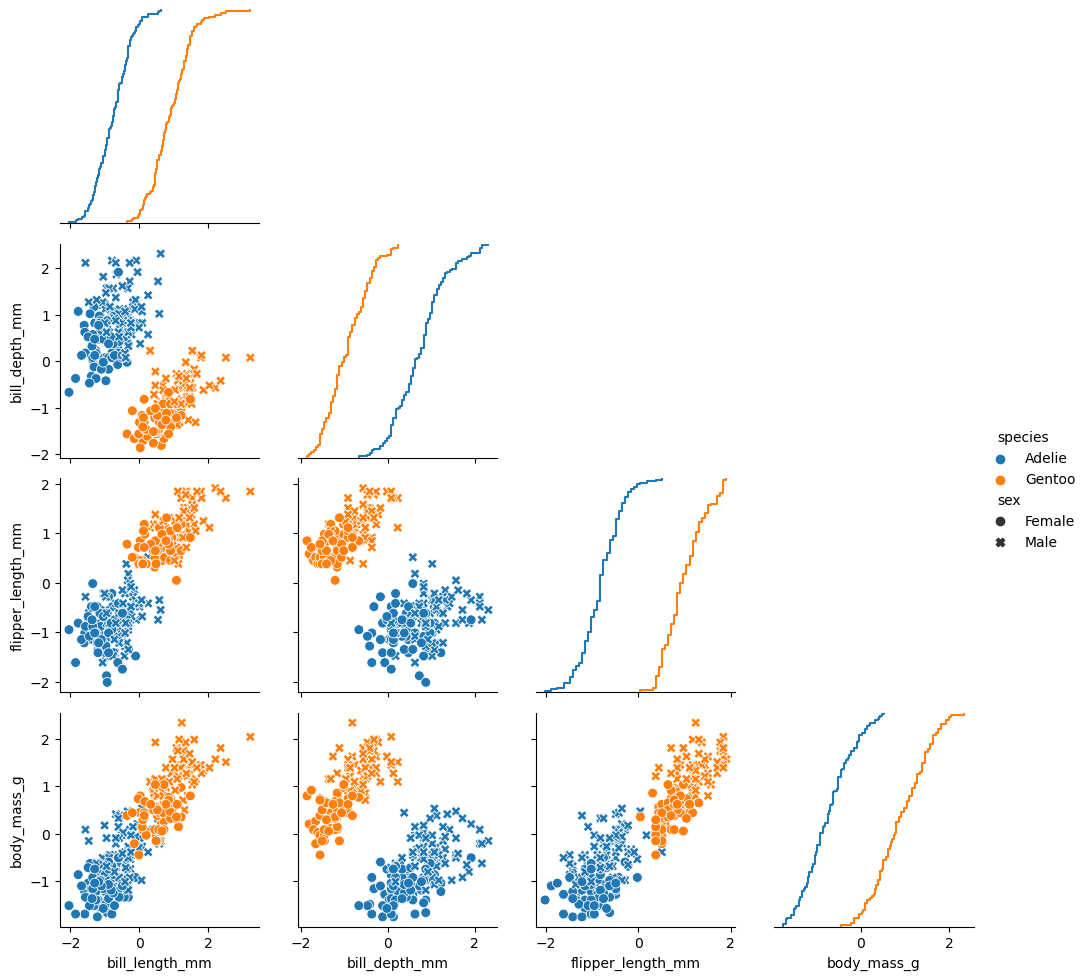

In [14]:
g = sns.PairGrid(X, hue="species", corner = True)
g.map_diag(sns.ecdfplot)
g.map_offdiag(sns.scatterplot, 
              style=penguins.sex,
              style_order = ["Female", "Male"],
              s = 50
              )
g.add_legend(title="", adjust_subtitles=True);
plt.show()

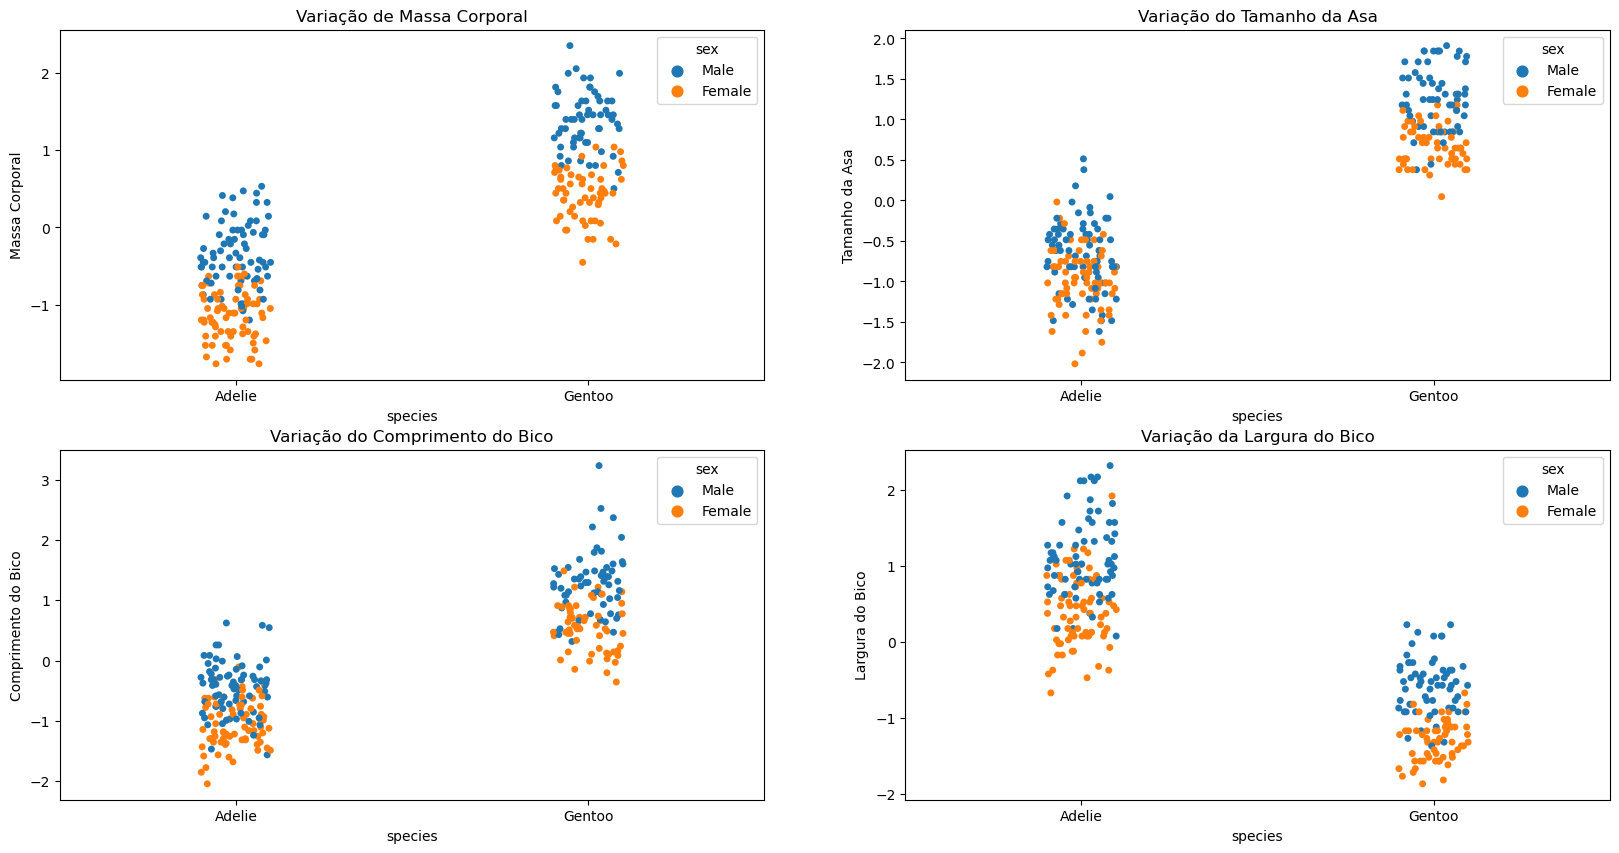

In [15]:
fig, axes = plt.subplots(2,2, figsize=(20,10))

sns.stripplot(data=X, x = "species", y = "body_mass_g", hue ="sex", ax = axes[0,0])
sns.stripplot(data=X, x = "species", y = "flipper_length_mm", hue ="sex", ax = axes[0,1])
sns.stripplot(data=X, x = "species", y = "bill_length_mm", hue ="sex", ax = axes[1,0])
sns.stripplot(data=X, x = "species", y = "bill_depth_mm", hue ="sex", ax = axes[1,1])

axes[0,0].set(title="Variação de Massa Corporal", ylabel = "Massa Corporal")
axes[0,1].set(title="Variação do Tamanho da Asa", ylabel = "Tamanho da Asa")
axes[1,0].set(title="Variação do Comprimento do Bico", ylabel = "Comprimento do Bico")
axes[1,1].set(title="Variação da Largura do Bico", ylabel = "Largura do Bico");

plt.show()

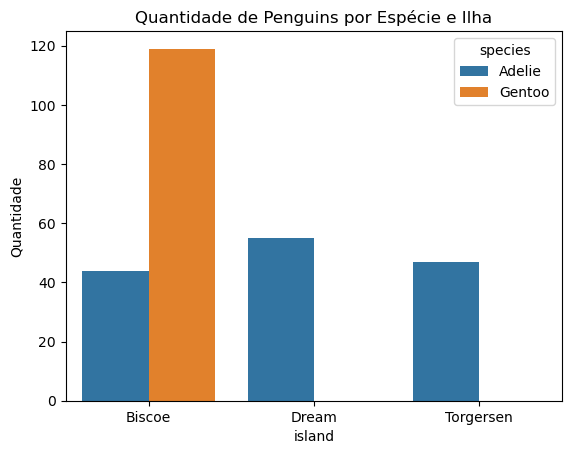

In [16]:
# Verificando a quantidade de penguins por ilha:

count_island = X.groupby(["island", "species"]).count()
count_island.reset_index(inplace=True)

sns.barplot(data=count_island,
           y = "body_mass_g",
           x = "island",
           hue="species"
            
).set(title="Quantidade de Penguins por Espécie e Ilha", 
      ylabel = "Quantidade")

plt.show()

## Analisando a distribuição da Espécie Adelie nas diferentes ilhas

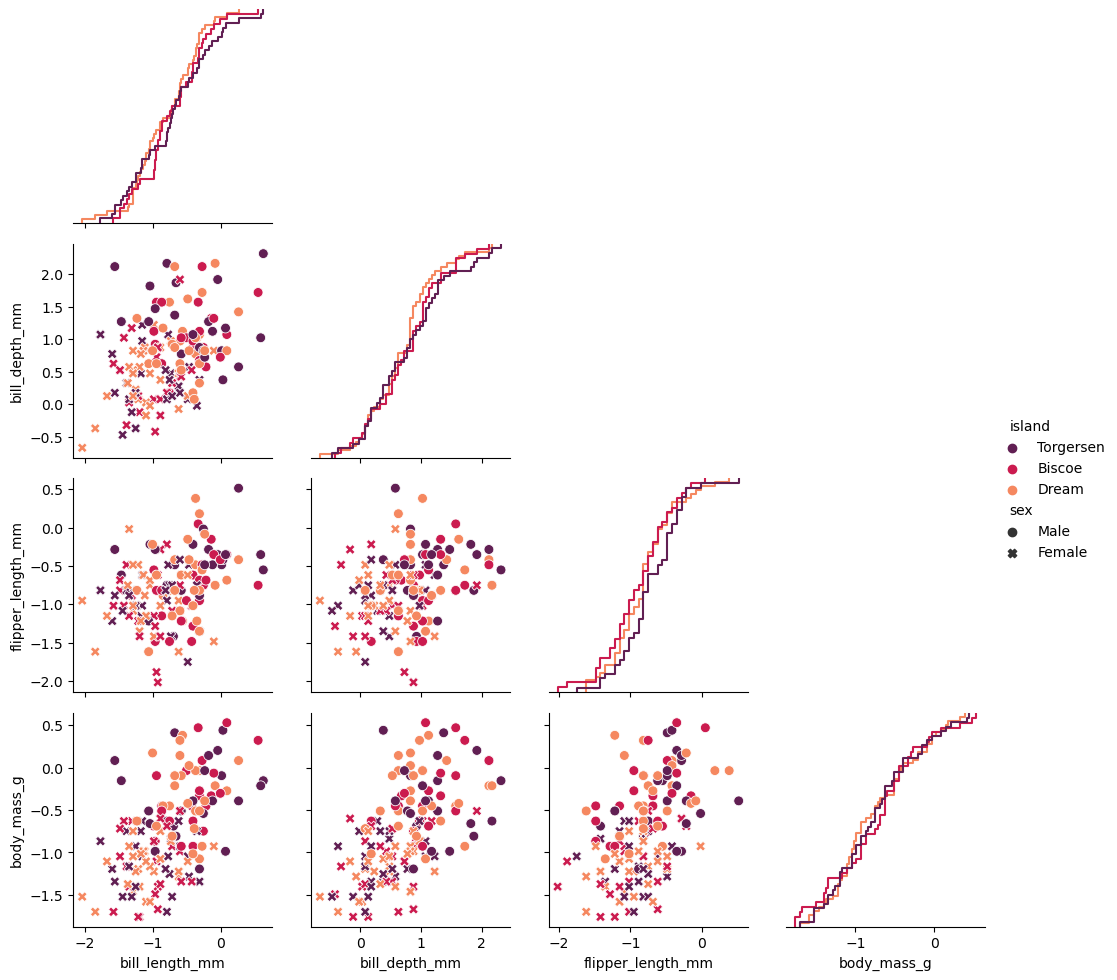

In [17]:
g = sns.PairGrid(X.loc[X.species == "Adelie"], hue="island", corner = True, palette = "rocket")
g.map_diag(sns.ecdfplot)
g.map_offdiag(sns.scatterplot, 
              style=X.sex,
              s = 50
              )
g.add_legend(title="", adjust_subtitles=True)
plt.show()

#### Como não é possível identificar um padrão na distribuição por ilhas, esse atributo será desconsiderado.

In [18]:
X.drop(["island"], axis = 1, inplace = True)
preds.drop(["island"], axis = 1, inplace = True)

# Preprocessing

### Obtendo a base de dados que usaremos no modelo:

In [19]:
Xm = X.copy()

In [20]:
Xm.head()

species  bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g  \
0  Adelie       -0.700039       0.924162          -1.417329    -0.689110   
1  Adelie       -0.623334       0.277324          -1.084416    -0.629568   
2  Adelie       -0.469925       0.575865          -0.485173    -1.284526   
4  Adelie       -1.160267       1.222703          -0.618338    -1.046360   
5  Adelie       -0.661687       1.869541          -0.818086    -0.808193   

      sex  
0    Male  
1  Female  
2  Female  
4  Female  
5    Male

In [21]:
y = Xm.pop("sex")

In [22]:
y = np.where(y == "Female", 1, 0)

In [23]:
encoder = OneHotEncoder(sparse=False)
encoded_X = encoder.fit_transform(Xm[["species"]])
encoded_X[:5]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [24]:
encoded_features = encoder.get_feature_names_out(['species'])
encoded_features

array(['species_Adelie', 'species_Gentoo'], dtype=object)

In [25]:
label_X = pd.DataFrame(encoded_X, columns = encoded_features)
label_X.head()

species_Adelie  species_Gentoo
0             1.0             0.0
1             1.0             0.0
2             1.0             0.0
3             1.0             0.0
4             1.0             0.0

In [26]:
Xm = pd.concat([label_X, Xm.select_dtypes(float).reset_index(drop=True)], axis=1)

In [27]:
Xm.head()

species_Adelie  species_Gentoo  bill_length_mm  bill_depth_mm  \
0             1.0             0.0       -0.700039       0.924162   
1             1.0             0.0       -0.623334       0.277324   
2             1.0             0.0       -0.469925       0.575865   
3             1.0             0.0       -1.160267       1.222703   
4             1.0             0.0       -0.661687       1.869541   

   flipper_length_mm  body_mass_g  
0          -1.417329    -0.689110  
1          -1.084416    -0.629568  
2          -0.485173    -1.284526  
3          -0.618338    -1.046360  
4          -0.818086    -0.808193

In [28]:
kmeans = KMeans(n_clusters=4)
Xc = Xm.copy()

Xc["cluster"] = kmeans.fit_predict(Xm)
Xc["cluster"] = Xc["cluster"].astype("category")

Xc.head()

species_Adelie  species_Gentoo  bill_length_mm  bill_depth_mm  \
0             1.0             0.0       -0.700039       0.924162   
1             1.0             0.0       -0.623334       0.277324   
2             1.0             0.0       -0.469925       0.575865   
3             1.0             0.0       -1.160267       1.222703   
4             1.0             0.0       -0.661687       1.869541   

   flipper_length_mm  body_mass_g cluster  
0          -1.417329    -0.689110       3  
1          -1.084416    -0.629568       3  
2          -0.485173    -1.284526       3  
3          -0.618338    -1.046360       3  
4          -0.818086    -0.808193       1

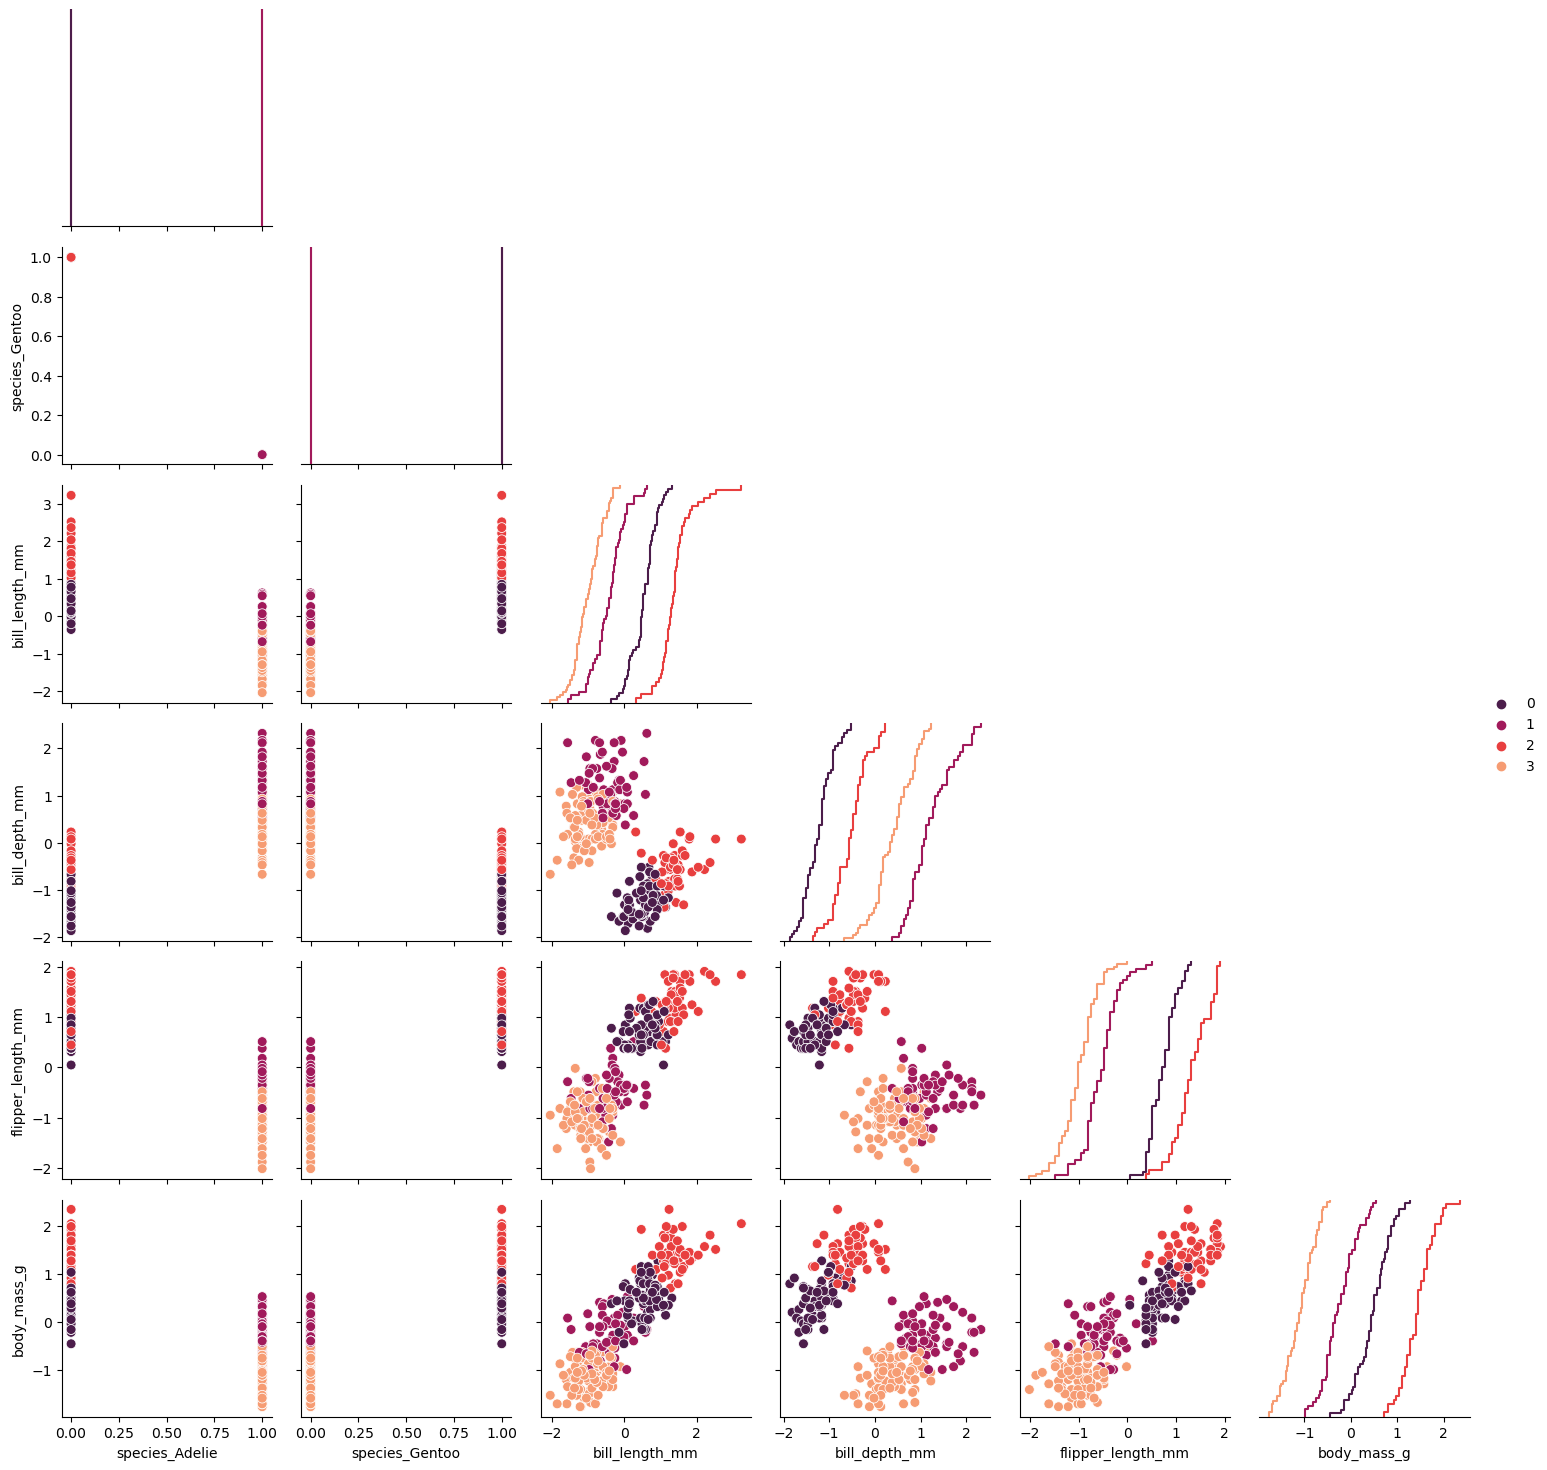

In [29]:
g = sns.PairGrid(Xc, hue="cluster", corner = True, palette = "rocket")
g.map_diag(sns.ecdfplot)
g.map_offdiag(sns.scatterplot, 
              s = 50
              )
g.add_legend(title="", adjust_subtitles=True)
plt.show()

#### Após a normalização dos dados, a distribuição dos clústers ficou bastante regular. Podemos ver que o programa é capaz de identificar claramente as epécies e o gênero.

In [30]:
X_train, X_test, y_train, y_test = train_test_split(Xc, y,
                                    test_size=0.3,
                                    random_state=1)

### Avaliando a quantidade de 'leaf nodes' do modelo e seu score:


In [31]:
for max_leaf_nodes in range(5, 50, 5):
    model=RandomForestClassifier(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(X_train, y_train)
    mae = mean_absolute_error(y_test, model.predict(X_test))

    print(f"Mae for MaxLeafNodes = {max_leaf_nodes}: {mae:.4f}")

Mae for MaxLeafNodes = 5: 0.0750
Mae for MaxLeafNodes = 10: 0.0500
Mae for MaxLeafNodes = 15: 0.0500
Mae for MaxLeafNodes = 20: 0.0500
Mae for MaxLeafNodes = 25: 0.0500
Mae for MaxLeafNodes = 30: 0.0500
Mae for MaxLeafNodes = 35: 0.0500
Mae for MaxLeafNodes = 40: 0.0500
Mae for MaxLeafNodes = 45: 0.0500


#### Perceba que a confiabilidade do modelo NÃO muda com o random_state!

In [32]:
model = RandomForestClassifier(max_leaf_nodes=10, random_state=0)
model.fit(X_train, y_train)
model.score(X_test, y_test) 

0.95

### Verificando a importância de cada atributo (feature):

In [33]:
ft = zip(model.feature_importances_, X_train.columns)
ft = sorted(list(ft), reverse = True)
ft

[(0.2582926863740089, 'cluster'),
 (0.2321743948962269, 'body_mass_g'),
 (0.22256612064653014, 'bill_depth_mm'),
 (0.16159748230058085, 'bill_length_mm'),
 (0.09057002235883695, 'flipper_length_mm'),
 (0.02409583641509306, 'species_Gentoo'),
 (0.010703457008723242, 'species_Adelie')]

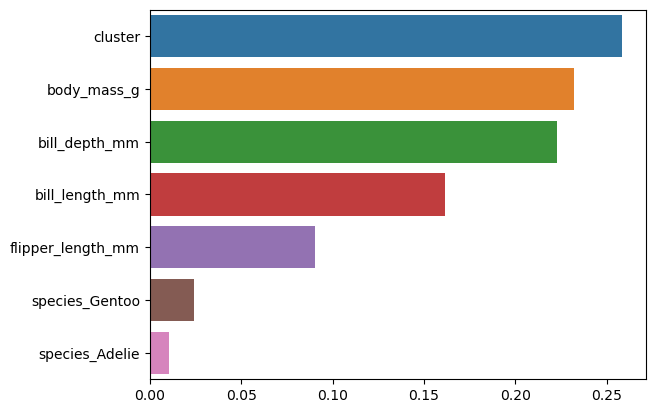

In [34]:
newx, newy = zip(*ft)
sns.barplot(x = list(newx), y = list(newy))
plt.show()

### Obtendo a base de dados que usaremos para as predições:

In [35]:
enc_preds = encoder.fit_transform(preds[["species"]])
enc_preds = pd.DataFrame(enc_preds, columns = encoded_features)

In [36]:
final_preds = pd.concat([enc_preds, preds.select_dtypes(float).reset_index(drop=True)], axis=1)

In [37]:
final_preds

species_Adelie  species_Gentoo  bill_length_mm  bill_depth_mm  \
0             1.0             0.0       -1.553876       0.650926   
1             1.0             0.0        0.151071       1.590049   
2             1.0             0.0       -0.755357       0.203725   
3             1.0             0.0       -0.755357       0.293165   
4             1.0             0.0       -0.820101       1.008687   
5             0.0             1.0        0.690612      -1.048438   
6             0.0             1.0        1.057499      -1.003718   
7             0.0             1.0        1.294897      -1.272039   
8             0.0             1.0        0.690612      -0.422357   

   flipper_length_mm  body_mass_g  
0          -0.363971    -0.780966  
1          -0.545956     0.359817  
2          -0.788603    -1.038562  
3          -1.152574    -0.449771  
4          -1.213236    -1.516954  
5           1.031250     0.139020  
6           0.909927     0.948608  
7           1.031250     1.059006  
8           1.091912     1.279802

In [38]:
preds_cluster = pd.concat([final_preds, Xm])

In [39]:
kmeans = KMeans(n_clusters=4)

preds_cluster["cluster"] = kmeans.fit_predict(preds_cluster)
preds_cluster["cluster"] = preds_cluster["cluster"].astype("category")

In [40]:
preds_clean = preds_cluster[:9]

In [41]:
preds_clean

species_Adelie  species_Gentoo  bill_length_mm  bill_depth_mm  \
0             1.0             0.0       -1.553876       0.650926   
1             1.0             0.0        0.151071       1.590049   
2             1.0             0.0       -0.755357       0.203725   
3             1.0             0.0       -0.755357       0.293165   
4             1.0             0.0       -0.820101       1.008687   
5             0.0             1.0        0.690612      -1.048438   
6             0.0             1.0        1.057499      -1.003718   
7             0.0             1.0        1.294897      -1.272039   
8             0.0             1.0        0.690612      -0.422357   

   flipper_length_mm  body_mass_g cluster  
0          -0.363971    -0.780966       2  
1          -0.545956     0.359817       0  
2          -0.788603    -1.038562       2  
3          -1.152574    -0.449771       2  
4          -1.213236    -1.516954       2  
5           1.031250     0.139020       3  
6           0.909927     0.948608       3  
7           1.031250     1.059006       1  
8           1.091912     1.279802       1

# Predições

In [42]:
predictions = model.predict(preds_clean)
predictions

array([0, 0, 0, 0, 0, 1, 1, 0, 0])

In [43]:
predictions = np.where(predictions == 1, "Female", "Male")
preds["sex"] = predictions.tolist()
preds

species  bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g  \
8    Adelie       -1.553876       0.650926          -0.363971    -0.780966   
9    Adelie        0.151071       1.590049          -0.545956     0.359817   
10   Adelie       -0.755357       0.203725          -0.788603    -1.038562   
11   Adelie       -0.755357       0.293165          -1.152574    -0.449771   
47   Adelie       -0.820101       1.008687          -1.213236    -1.516954   
246  Gentoo        0.690612      -1.048438           1.031250     0.139020   
286  Gentoo        1.057499      -1.003718           0.909927     0.948608   
324  Gentoo        1.294897      -1.272039           1.031250     1.059006   
336  Gentoo        0.690612      -0.422357           1.091912     1.279802   

        sex  
8      Male  
9      Male  
10     Male  
11     Male  
47     Male  
246  Female  
286  Female  
324    Male  
336    Male

### Base de Dados Final
Juntando as predições à base de dados inicial, através do indice:

In [44]:
for i in preds.index:
    penguins["sex"][i] = preds["sex"][i]

In [45]:
penguins.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 342 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            342 non-null    object 
 1   island             342 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                342 non-null    object 
dtypes: float64(4), object(3)
memory usage: 29.5+ KB


In [46]:
penguins

species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0    Adelie  Torgersen            39.1           18.7              181.0   
1    Adelie  Torgersen            39.5           17.4              186.0   
2    Adelie  Torgersen            40.3           18.0              195.0   
4    Adelie  Torgersen            36.7           19.3              193.0   
5    Adelie  Torgersen            39.3           20.6              190.0   
..      ...        ...             ...            ...                ...   
338  Gentoo     Biscoe            47.2           13.7              214.0   
340  Gentoo     Biscoe            46.8           14.3              215.0   
341  Gentoo     Biscoe            50.4           15.7              222.0   
342  Gentoo     Biscoe            45.2           14.8              212.0   
343  Gentoo     Biscoe            49.9           16.1              213.0   

     body_mass_g     sex  
0         3750.0    Male  
1         3800.0  Female  
2         3250.0  Female  
4         3450.0  Female  
5         3650.0    Male  
..           ...     ...  
338       4925.0  Female  
340       4850.0  Female  
341       5750.0    Male  
342       5200.0  Female  
343       5400.0    Male  

[342 rows x 7 columns]